# ResNet50 Model Trained from Scratch
This file is used to train a ResNet50 model from scratch on the adapted cars dataset (49 classes, images cropped around the bounding boxes, and 50% more training data).

In [1]:
# importing libaries
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Add, ReLU, Dense
from tensorflow.keras import Model

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
gen_params = {"rescale":1.0/255,
              "featurewise_center":False,
              "samplewise_center":False,
              "featurewise_std_normalization":False,
              "samplewise_std_normalization":False,
              "zca_whitening":False,
              "rotation_range":20,
              "width_shift_range":0.1,
              "height_shift_range":0.1,
              "shear_range":0.2,
              "zoom_range":0.1,
              "horizontal_flip":True,
              "fill_mode":'constant',
              "cval": 0,
              "validation_split":0.2}

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)


## Data generator for training images
train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/car_data/train',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='training')

val_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/car_data/train',
                                                    class_mode='categorical', batch_size = 32, 
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='validation')

test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/car_data/test',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True)

Found 9743 images belonging to 49 classes.
Found 2416 images belonging to 49 classes.
Found 4026 images belonging to 49 classes.


In [9]:
from keras.applications.resnet50 import ResNet50

base = ResNet50(include_top=False,weights=None,input_shape=(224,224,3))

input = tf.keras.layers.Input(shape=(224,224,3))
x1= base(input)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(49, activation='softmax')(x2)
model = tf.keras.models.Model(input, out)

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 49)                4917297   
Total params: 28,505,009
Trainable params: 28,451,889
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
model_name = "resnet50_cars_49_scratch.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [11]:
batch = 128
num_epochs = 100

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=num_epochs,
                    verbose=1,
                    batch_size=batch,
                    callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/100
305/305 [==============================] - 226s 701ms/step - loss: 8.1814 - accuracy: 0.0559 - val_loss: 3.9513 - val_accuracy: 0.0476
Epoch 2/100
305/305 [==============================] - 210s 689ms/step - loss: 4.9829 - accuracy: 0.0796 - val_loss: 5.1870 - val_accuracy: 0.1138
Epoch 3/100
305/305 [==============================] - 208s 681ms/step - loss: 4.5543 - accuracy: 0.0971 - val_loss: 17.8688 - val_accuracy: 0.1043
Epoch 4/100
305/305 [==============================] - 211s 690ms/step - loss: 4.5961 - accuracy: 0.0998 - val_loss: 10.4035 - val_accuracy: 0.1080
Epoch 5/100
305/305 [==============================] - 208s 682ms/step - loss: 3.9822 - accuracy: 0.1233 - val_loss: 5.7423 - val_accuracy: 0.1304
Epoch 6/100
305/305 [==============================] - 209s 684ms/step - loss: 3.7899 - accuracy: 0.1217 - val_loss: 3.7837 - val_accuracy: 0.1333
Epoch 7/100
305/305 [==============================] - 208s 681ms/step - loss: 3.6888 - accuracy: 0.1239 - val_loss:

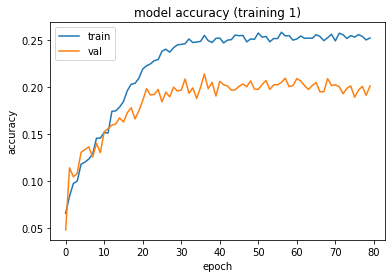

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy (training 1)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
metrics = model.evaluate(test_generator)

126/126 [==============================] - 28s 224ms/step - loss: 2.9804 - accuracy: 0.2072


In [15]:
max(history.history['val_accuracy'])

0.21399006247520447

In [16]:
max(history.history['accuracy'])

0.2584419548511505